<a href="https://colab.research.google.com/github/priyanbhatt/Testing-the-Generalization-Hypothesis-in-Deepfake-Detection/blob/main/images_to_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Check for available GPUs and configure TensorFlow to use one
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Set the GPU to be used
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)

In [ ]:
# Detect and initialize the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Storing images as tfrecords

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
import random # Import the random module for sampling

# ------------------ Paths ------------------
real_faces_dir = '/content/drive/MyDrive/Research Project/dataset/Real_Face_128 x 128'
stylegan2_dir = '/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN2_256x256'
stylegan3_dir = '/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN3_256x256'

# Get file paths
real_faces = [os.path.join(real_faces_dir, f) for f in os.listdir(real_faces_dir) if f.endswith('.png')]
stylegan2_all = [os.path.join(stylegan2_dir, f) for f in os.listdir(stylegan2_dir) if f.endswith('.png')]
stylegan3_all = [os.path.join(stylegan3_dir, f) for f in os.listdir(stylegan3_dir) if f.endswith('.png')]

# Sample 3550 images from StyleGAN2 and StyleGAN3
num_samples = 3550
stylegan2_sampled = random.sample(stylegan2_all, min(num_samples, len(stylegan2_all)))
stylegan3_sampled = random.sample(stylegan3_all, min(num_samples, len(stylegan3_all)))


# Print file paths for StyleGAN3
i=1
print("realface file paths:")
for path in real_faces:
    print(path)
    i=i+1
    if i==5:
      break
i=1
print("stylegan2 file paths:")
for path in stylegan2_sampled:
    print(path)
    i=i+1
    if i==5:
      break
i=1
print("stylegan3 file paths:")
for path in stylegan3_sampled:
    print(path)
    i=i+1
    if i==5:
      break

# Labels
labels_real = [0] * len(real_faces)
labels_stylegan2 = [1] * len(stylegan2_sampled)
labels_stylegan3 = [1] * len(stylegan3_sampled)

# Combine
all_paths = real_faces + stylegan2_sampled + stylegan3_sampled
all_labels =labels_real + labels_stylegan2 +labels_stylegan3

# ------------------ TFRecord helpers ------------------
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image_path, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    Takes image path and label as input.
    """
    try:
        img_raw = tf.io.read_file(image_path)
        img = tf.io.decode_png(img_raw, channels=3)
        img = tf.image.resize(img, (224, 224), method=tf.image.ResizeMethod.LANCZOS5)
        img = tf.cast(img, tf.uint8)
        img_bytes = tf.io.encode_png(img)
        feature = {
            'image': _bytes_feature(img_bytes.numpy()),
            'label': _int64_feature(label),
        }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


def write_shard(shard_paths, shard_labels, shard_filename):
    """
    Writes a shard of data to a TFRecord file.
    """
    with tf.io.TFRecordWriter(shard_filename) as writer:
        for path, label in zip(shard_paths, shard_labels):
            example = serialize_example(path, label)
            if example:
                writer.write(example)

def write_tfrecords_multiprocess(paths, labels, filename_prefix, num_shards=1):
    """
    Writes data to sharded TFRecord files using multiprocessing.
    """
    total_samples = len(paths)
    shard_size = total_samples // num_shards
    if total_samples % num_shards != 0:
        num_shards += 1

    print(f"Writing {total_samples} samples to {num_shards} shards...")

    with ThreadPoolExecutor(max_workers=num_shards) as executor:
        futures = []
        for i in range(num_shards):
            start_index = i * shard_size
            end_index = min((i + 1) * shard_size, total_samples)
            shard_paths = paths[start_index:end_index]
            shard_labels = labels[start_index:end_index]
            shard_filename = f'{filename_prefix}-{i:05d}-of-{num_shards:05d}.tfrecord'
            futures.append(executor.submit(write_shard, shard_paths, shard_labels, shard_filename))

        for future in as_completed(futures):
            try:
                future.result()
            except Exception as exc:
                print(f'Shard writing generated an exception: {exc}')

# ------------------ Split data ------------------
X_train, X_test,  y_train, y_test = train_test_split(
    all_paths,all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# ------------------ Save TFRecords ------------------
output_dir = "/content/drive/MyDrive/Research Project/dataset/RealFace_Stylegan2_Stylegan3"
os.makedirs(output_dir, exist_ok=True)

write_tfrecords_multiprocess(X_train, y_train, os.path.join(output_dir, "RealFace_Stylegan2_Stylegan3_train"))
write_tfrecords_multiprocess(X_test, y_test, os.path.join(output_dir, "RealFace_Stylegan2_Stylegan3_test"))

print("✅ TFRecords created at:", output_dir)

realface file paths:
/content/drive/MyDrive/Research Project/dataset/Real_Face_128 x 128/60458.png
/content/drive/MyDrive/Research Project/dataset/Real_Face_128 x 128/59421.png
/content/drive/MyDrive/Research Project/dataset/Real_Face_128 x 128/59511.png
/content/drive/MyDrive/Research Project/dataset/Real_Face_128 x 128/60084.png
stylegan2 file paths:
/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN2_256x256/StyleGAN_2 (649).png
/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN2_256x256/StyleGAN_2 (6490).png
/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN2_256x256/StyleGAN_2 (6491).png
/content/drive/MyDrive/Research Project/dataset/Fake_Faces_generated_from_GANs/GAN_Generated_Fake_Images/StyleGAN2_256x256/StyleGAN_2 (6492).png
Writing 11360 samples to 1 shards...
Writing 2840 samples to 1 sha

In [ ]:
import tensorflow as tf
import os
from collections import Counter

# Define the output directory for TFRecords (should be the same as the saving directory)
output_dir = "/content/drive/MyDrive/Research Project/dataset/RealFace_Stylegan2" # Ensure this matches the directory used for saving

# Define the feature description for parsing the TFRecord files
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def decode_image(parsed_example):
    # Decode the raw PNG image string into a 3D tensor
    image = tf.io.decode_png(parsed_example['image'], channels=3)
    # Convert to float32 (optional, depending on your model's input requirements)
    image = tf.cast(image, tf.float32)
    return image, parsed_example['label']

def load_tfrecord_dataset(filepaths):
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(filepaths)
    # Parse and decode the examples
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.map(decode_image)
    return dataset

def get_tfrecord_files(directory, prefix):
    """Gets a list of TFRecord files in a directory with a given prefix."""
    filepaths = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith(prefix) and f.endswith('.tfrecord')]
    filepaths.sort() # Ensure consistent order
    return filepaths

def check_uniqueness_and_labels_batch(dataset, dataset_name, batch_size=128):
    """Checks for uniqueness of first N images and counts labels in a dataset."""
    print(f"\nChecking uniqueness and label distribution for {dataset_name}:")
    images_bytes = []
    labels = []
    count = 0
    # Take the first batch_size examples
    for image, label in dataset.take(batch_size):
        try:
            # Convert back to uint8 and encode to PNG bytes for consistent representation
            img_bytes = tf.io.encode_png(tf.cast(image, tf.uint8)).numpy()
            images_bytes.append(img_bytes)
            labels.append(label.numpy())
            count += 1
        except Exception as e:
            print(f"Error processing example {count}: {e}")
            # Continue processing other examples
            pass

    print(f"Processed {count} examples from the first batch.")

    if len(images_bytes) > 0:
        if len(set(images_bytes)) == len(images_bytes):
            print(f"First {count} images in the batch are unique.")
        else:
            print(f"First {count} images in the batch contain duplicates.")

        label_counts = Counter(labels)
        print(f"Label distribution for the first {count} examples: {label_counts}")
    else:
        print(f"Could not process any examples to check uniqueness or labels.")

def compare_datasets_for_duplicates(dataset1, dataset2, dataset1_name, dataset2_name, num_examples_to_compare=None):
    """Compares images between two datasets to check for duplicates."""
    print(f"\nComparing {dataset1_name} and {dataset2_name} for duplicates:")

    images1_bytes = set()
    images2_bytes = set()
    duplicate_count = 0

    print(f"Loading images from {dataset1_name}...")
    for i, (image, _) in enumerate(dataset1):
        if num_examples_to_compare is not None and i >= num_examples_to_compare:
            break
        try:
            img_bytes = tf.io.encode_png(tf.cast(image, tf.uint8)).numpy()
            images1_bytes.add(bytes(img_bytes)) # Use bytes for hashing in set
        except Exception as e:
            print(f"Error processing image {i} from {dataset1_name}: {e}")


    print(f"Loading images from {dataset2_name}...")
    for i, (image, _) in enumerate(dataset2):
        if num_examples_to_compare is not None and i >= num_examples_to_compare:
            break
        try:
            img_bytes = tf.io.encode_png(tf.cast(image, tf.uint8)).numpy()
            if bytes(img_bytes) in images1_bytes:
                duplicate_count += 1
            images2_bytes.add(bytes(img_bytes)) # Use bytes for hashing in set
        except Exception as e:
            print(f"Error processing image {i} from {dataset2_name}: {e}")

    print(f"Found {duplicate_count} duplicates between {dataset1_name} and {dataset2_name}.")
    if duplicate_count == 0:
        print("No duplicates found between the two datasets.")
    else:
        print("Duplicates found between the two datasets.")


# Get the file paths for each dataset
train_filepaths = get_tfrecord_files(output_dir, 'RealFace_Stylegan2_train')
test_filepaths = get_tfrecord_files(output_dir, 'RealFace_Stylegan2_test')

# Load the full datasets
train_dataset = load_tfrecord_dataset(train_filepaths)
test_dataset = load_tfrecord_dataset(test_filepaths)

# Check the first batch of each dataset (optional, as requested before)
# check_uniqueness_and_labels_batch(train_dataset, "Training Dataset")
# check_uniqueness_and_labels_batch(test_dataset, "Test Dataset")

# Compare the train and test datasets for duplicates
# Be cautious with large datasets, this can be memory intensive
# You can limit the number of examples to compare by setting num_examples_to_compare
compare_datasets_for_duplicates(train_dataset, test_dataset, "Training Dataset", "Test Dataset")


Comparing Training Dataset and Test Dataset for duplicates:
Loading images from Training Dataset...
Loading images from Test Dataset...
Found 0 duplicates between Training Dataset and Test Dataset.
No duplicates found between the two datasets.


In [ ]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/Research Project/dataset/Stylegan2_realface/train_dataset')
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/Research Project/dataset/Stylegan2_realface/val_dataset')
test_dataset = tf.data.Dataset.load('/content/drive/MyDrive/Research Project/dataset/Stylegan2_realface/Stylegan2_realfacetest_dataset')

# Function to count labels in a dataset
def count_labels(dataset):
    labels = [label.numpy() for _, label in dataset]
    return Counter(labels)

# Print the label counts for each dataset
train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

print(f"Training set label 0 count: {train_counts[0]}")
print(f"Training set label 1 count: {train_counts[1]}")
print(f"Validation set label 0 count: {val_counts[0]}")
print(f"Validation set label 1 count: {val_counts[1]}")
print(f"Test set label 0 count: {test_counts[0]}")
print(f"Test set label 1 count: {test_counts[1]}")


# Function to check for uniqueness of first 25 images
def check_uniqueness(dataset, dataset_name):
    print(f"\nChecking uniqueness for {dataset_name}:")
    images = [img.numpy().tobytes() for img, _ in dataset.take(25)]
    if len(set(images)) == len(images):
        print("First 25 images are unique.")
    else:
        print("First 25 images contain duplicates.")

# Check uniqueness for each dataset
check_uniqueness(train_dataset, "Training Dataset")
check_uniqueness(val_dataset, "Validation Dataset")
check_uniqueness(test_dataset, "Test Dataset")

Training set label 0 count: 4970
Training set label 1 count: 4970
Validation set label 0 count: 1065
Validation set label 1 count: 1065
Test set label 0 count: 1065
Test set label 1 count: 1065

Checking uniqueness for Training Dataset:
First 25 images are unique.

Checking uniqueness for Validation Dataset:
First 25 images are unique.

Checking uniqueness for Test Dataset:
First 25 images are unique.


All train TFRecord files: ['/content/drive/My Drive/Research Project/dataset/Real_Face/train.tfrecord', '/content/drive/My Drive/Research Project/dataset/Stylegan2/train.tfrecord']
Datasets are loaded from TFRecord shards, batched, prefetched, and cached.

Training set label counts: {np.int32(1): 5325, np.int32(0): 5250}

Displaying 10 sample images from the training dataset:


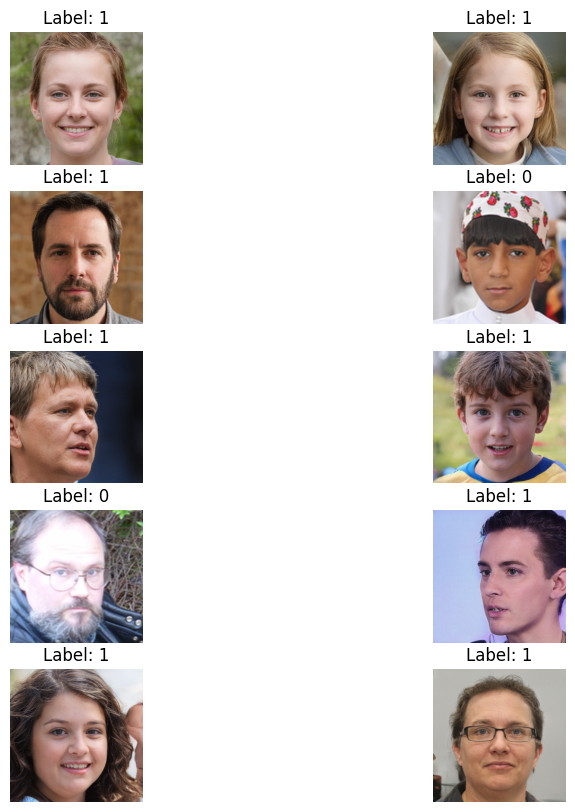

In [ ]:
import matplotlib.pyplot as plt
import random

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary below.
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_png(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    label = tf.cast(example['label'], tf.int32)
    return image, label

def dataset_from_tfrecords(tfrecords_paths, batch_size=32, shuffle=False, shuffle_buffer=1024): # Set a default batch size
    if not tfrecords_paths:
        print("Warning: tfrecords_paths is empty, returning an empty dataset.")
        return tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))

    files_ds = tf.data.Dataset.from_tensor_slices(tfrecords_paths)
    if shuffle:
        files_ds = files_ds.shuffle(len(tfrecords_paths))

    ds = files_ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

real_face_train="/content/drive/My Drive/Research Project/dataset/Real_Face/train.tfrecord"
stylegan2_train="/content/drive/My Drive/Research Project/dataset/Stylegan2/train.tfrecord"

real_face_test="/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord"
stylegan2_test="/content/drive/My Drive/Research Project/dataset/Stylegan2/test.tfrecord"
# Combine the two lists of TFRecord file paths
all_train_tfrecords = [real_face_train ,stylegan2_train]
all_test_tfrecords = [real_face_test ,stylegan2_test]
print("All train TFRecord files:", all_train_tfrecords)

train_dataset = dataset_from_tfrecords(all_train_tfrecords, batch_size=32, shuffle=True) # Use default or specified batch size
test_dataset = dataset_from_tfrecords(all_test_tfrecords, batch_size=32, shuffle=True) # Use default or specified batch size


print("Datasets are loaded from TFRecord shards, batched, prefetched, and cached.")

# Calculate and print label counts for the training dataset
label_counts = {}
for _, label in train_dataset.unbatch():
    label = label.numpy()
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1

print(f"\nTraining set label counts: {label_counts}")


# Show 10 images from the training dataset
print("\nDisplaying 10 sample images from the training dataset:")
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.unbatch().take(10)):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
plt.show()